In [1]:
import sys
import os

# Path to the folder containing your module
module_path = os.path.abspath("/Users/bb24144/Documents/QENS_investigation/QENStin/module")
if module_path not in sys.path:
    sys.path.append(module_path)



import scipp as sc
import Sprede as sp
import MDAnalysis as mda
from pymatgen.io.vasp import Xdatcar
from pymatgen.core import Structure
import kinisi.parser as parser
import numba as numba


# Checker

In [2]:
import numpy as np
np.random.seed(42)

atoms = 1000

# 128 particles, 3 ovservations of 3 dimensions
disp_frames =  np.random.randint(low = 2, high =10, size = (atoms,10000,3))

# 3 3d q vectors
q_points = np.random.randint(low = 0, high =5, size = (5,3))


d_q = (disp_frames @ q_points.T)


exp_d_q = np.exp(1j* d_q)
mean_exp = exp_d_q.mean(axis = 2)
b_2 = np.random.randint(low = 10, high =150, size = (atoms,1))
incoh_sum = (mean_exp * b_2).real
incoh_final = np.mean(incoh_sum)

incoh_final

-0.10847798136910836

# Numba

In [14]:
import numpy as np
from numba import njit


In [16]:
@numba.njit
def create_disp_3d(disp, i, unit='A'):
    """
    From a displacement array calculate the 3d displacements for a given time interval
    """
    n, m, t = disp.shape
    # Initialize the output array
    result = np.zeros((m, n-i, t), dtype=disp.dtype)
    # Compute the displacements
    result[:, 0, :] = disp[i, :, :]  # Base case
    for j in numba.prange(1, n - i):
        result[:, j, :] = disp[i+j,:, :] - disp[j-1,:, :]
    
    if unit == 'A':
        return result
    elif unit =='nm':
        return result / 10
    else:
        raise ValueError('unit must be either A or Nm')

In [17]:
@numba.jit(fastmath=True, nopython=True, parallel=True)
def mat_mul(a,b):
    """
    3d x 2d matrix multiplication using numba

    i.e. 
    a is a 3d array of shape (n,m,t)
    b is a 2d array of shape (t,p)

    The result is a 3d array of shape (n,m,p) where the last dimension is the dot product of the last dimension of a and b
    """
    result_shape = a.shape[:-1] + (b.shape[0],) 
    result = np.zeros(result_shape,dtype = np.float64)

    for i in numba.prange(a.shape[0]):  
        for j in numba.prange(a.shape[1]):  
            for k in numba.prange(b.shape[0]): 
                for l in numba.prange(a.shape[2]):  # Inner dimension for dot product
                    result[i, j, k] += a[i, j, l] * b[k, l]
    return result


In [18]:
@numba.jit(fastmath=True, nopython=True, parallel=True)
def mean_axis_2(array):
    """
    Mean along the 2nd axis of a 3d array
    
    """

    result = np.zeros((array.shape[0],array.shape[1]), dtype = np.float64)
    array = array.real

    for x in numba.prange(array.shape[0]):
        for y in numba.prange(array.shape[1]):
            for z in numba.prange(array.shape[2]):
                result[x,y] += array[x,y,z]
            result[x,y] = result[x,y] / array.shape[2]

    return result

In [19]:
@numba.jit(fastmath=True, nopython=True, parallel=True)
def calc_incoh_f(disp_3d:np.ndarray,
         q_points: np.ndarray, 
         s_len_sq: np.ndarray) -> np.ndarray:
    """
    Calculate the incoherent intermediete scattering function F(q,t) as per eqn17 in https://doi.org/10.1016/0010-4655(95)00048-K

    :param q_points: Chosen q_points in 3 dimensional cartesian coordinates, shape [q_points x 3]

    :returns: Point along F(q_t) line for the chosen 3d displacement and q_point

    expects an input of X atoms by N observations by 3 dimensions


    """
    result = mat_mul(disp_3d,q_points)

    #numba raise to exponent implementation
    expensive_exponent = np.zeros(result.shape, dtype=np.complex64)
    for x in numba.prange(result.shape[0]):
        for y in numba.prange(result.shape[1]):
            expensive_exponent[x, y] = np.exp(1j * result[x, y])


    # Numba axis mean implementation
    mean_1 = mean_axis_2(expensive_exponent)

    # Numba sum over implementation and divide by N
    incoh_val = np.zeros(1,dtype = np.float64)
    for x in numba.prange(mean_1.shape[0]):
        for y in numba.prange(mean_1.shape[1]):
            incoh_val += mean_1[x,y] * s_len_sq[x]

    incoh_f = incoh_val / (mean_1.shape[0]*mean_1.shape[1])

    return incoh_f

In [20]:
def incoh_line(disp,q_points,dt,total_scat_lengths,min_required_points= 10000, unit = 'A'):
    """
    Calc the incoherent intermediate scattering function F(q,t) for a given 3d displacement and q_shell, based on min required points.
    Input of non square scattering lengths is expected

    """

    s_len_sq = np.zeros(total_scat_lengths.shape, dtype=np.float64)
    for x in range(0, s_len_sq.shape[0]):
        s_len_sq[x] = total_scat_lengths[x]**2

    incoh_line = np.zeros((dt.shape[0] - min_required_points), dtype=np.float64)

    for i in range(0, (dt.shape[0]-min_required_points)):
        if i % 3000 == 0:
            print(i)
        disp_3d = create_disp_3d(disp,i,unit)
        incoh_line[i] = calc_incoh_f(disp_3d,q_points,s_len_sq)

    return incoh_line



# Kinisi test

In [21]:
x = Xdatcar("XDATCAR_reduced_50_wrapped.vasp")

import warnings
warnings.filterwarnings("ignore")

time_step = 1.0 * sc.Unit('fs')
step_skip = 50 * sc.Unit('dimensionless')

In [10]:
z = sp.PymatgenParser(x.structures, specie = ['Li','N', 'H'], isotopes = ['7Li','14N', '1H'], time_step = time_step, step_skip = step_skip)

q_points = z.calculate_q_points(q_max = 18, max_points = 8)

Reading Trajectory:   0%|          | 0/20000 [00:00<?, ?it/s]

Reading Trajectory: 100%|██████████| 20000/20000 [00:00<00:00, 38129.88it/s]


INFO: Pruning at 0.26 < 18
INFO: Pruned from 13934 q-points to 13


In [11]:
kin_H = parser.PymatgenParser(x.structures, time_step = time_step, step_skip = step_skip, specie = ['Li','N', 'H'])

structure, coords, latt = kin_H.get_structure_coords_latt(x.structures)
kin_H.displacements = kin_H.calculate_displacements(coords = coords, lattice= latt)

Reading Trajectory: 100%|██████████| 20000/20000 [00:00<00:00, 44421.54it/s]


In [12]:
import numpy as np
np.random.seed(42)
def random_points_on_sphere(radius=1.0, nPoints=100):
    points = np.zeros((3, nPoints), dtype=np.float64)

    theta = 2.0 * np.pi * np.random.uniform(nPoints)
    u = np.random.uniform(-1.0, 1.0, nPoints)
    points[0, :] = radius * np.sqrt(1 - u**2) * np.cos(theta)
    points[1, :] = radius * np.sqrt(1 - u**2) * np.sin(theta)
    points[2, :] = radius * u

    return points


width = 1
nVectors = 10
shells = np.arange(1.8,18,2)


q_vec = np.zeros((len(shells),3,nVectors))

for i,q in enumerate(shells):
    fact = q * np.sign(
                np.random.uniform(-0.5, 0.5, nVectors)
            ) + width * np.random.uniform(-0.5, 0.5, nVectors)
    v = random_points_on_sphere(nPoints=nVectors)

    q_vec[i] = fact * v

#q_vec = q_vec.reshape(3,10).T


In [22]:
incoh_full = incoh_full = np.zeros((9,10000))

for iter in range(q_vec.shape[0]):
    print(iter)
    q_vec_choice = q_vec[iter].T
    incoh_test = incoh_line(q_points=q_vec_choice,disp =kin_H.displacements.values, dt = z.delta_t.values,total_scat_lengths=z.scattering_lengths, min_required_points=10000,unit ='nm')
    incoh_full[iter] = incoh_test

0
0
3000
6000
9000
1
0
3000
6000
9000
2
0
3000
6000
9000
3
0
3000
6000
9000
4
0
3000
6000
9000
5
0
3000
6000
9000
6
0
3000
6000
9000
7
0
3000
6000
9000
8
0
3000
6000
9000


In [ ]:
tester = create_disp_3d(disp=kin_H.displacements.values,i=10)

In [90]:
q_points

array([[3, 0, 0],
       [2, 2, 1],
       [3, 3, 2],
       [3, 3, 0],
       [2, 4, 2]])

In [97]:
import numpy as np
np.random.seed(42)

atoms = 4

# 4, 3 ovservations of 3 dimensions
disp_frames =  np.random.randint(low = 2, high =10, size = (atoms,3,3))
#disp_frames = tester

# 5 3d q vectors
q_points = np.random.randint(low = 0, high =5, size = (5,3))
#q_points = q_vec


d_q = (disp_frames @ q_points.T)
# print(d_q)
print(d_q)

exp_d_q = np.exp(1j* d_q)
mean_exp = exp_d_q.mean(axis = 2)
print(mean_exp.shape)
b_2 = np.ones(atoms) 
incoh_sum = (b_2[:,np.newaxis]* mean_exp ).real
print(incoh_sum.shape)
incoh_final = np.mean(incoh_sum)

incoh_final

[[[24 32 51 39 48]
  [24 33 54 36 50]
  [18 32 52 36 52]]

 [[ 9 22 37 21 38]
  [12 25 42 24 42]
  [18 31 51 33 50]]

 [[27 33 53 39 48]
  [18 27 45 27 42]
  [15 31 50 36 52]]

 [[ 9 29 46 36 52]
  [18 21 34 24 30]
  [ 9 26 42 30 46]]]
(4, 3)
(4, 3)


0.05045544121918207

In [ ]:
calc_incoh_f(tester,q_vec,z.scattering_lengths ** 2)

array([152.04116045])

In [32]:
incoh_full.shape

(9, 10000)

In [75]:
incoh_full.shape

(9, 10000)

In [23]:
incoh_test2 = incoh_full / incoh_full[:,0].reshape(9,1)

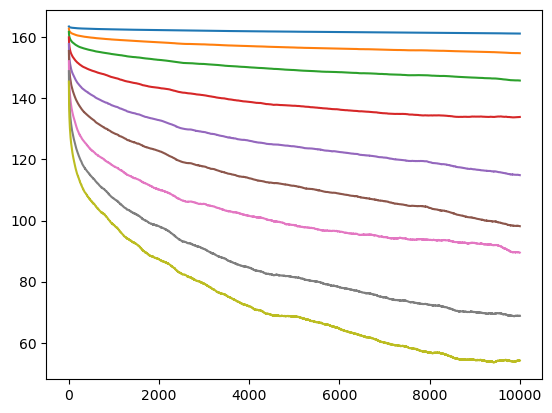

In [24]:
import matplotlib.pyplot as plt
#incoh_plot = incoh_test / incoh_test[0]

# Normalise based on sum of scattering lengths 
# In

for x in range(incoh_full.shape[0]):
    plt.plot(np.linspace(0,10000,10000),incoh_full[x])

(0.3, 1.0)

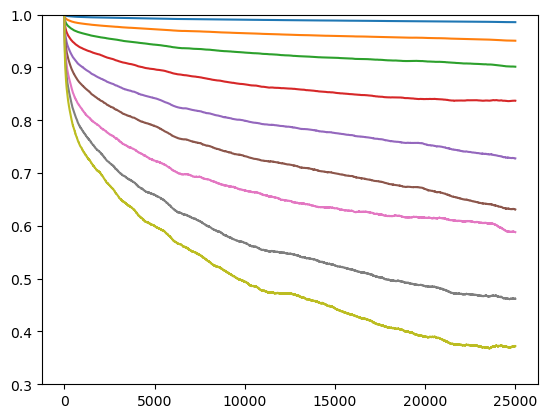

In [29]:
import matplotlib.pyplot as plt
#incoh_plot = incoh_test / incoh_test[0]

# Look at conversion from A to nm - convert A to nm 

for x in range(incoh_full.shape[0]):
    plt.plot(np.linspace(0,25000,10000),incoh_test2[x])

plt.ylim(0.3,1)

In [ ]:
x = np.fft.fft(incoh_full[0])